# Utilizando um outro modelo linear
- Vamos introduzir o conceito de **Regularização**:  
Regularização é uma técnica utilizada em machine learning para prevenir overfitting, que ocorre quando um modelo se ajusta excessivamente aos dados de treinamento, capturando não apenas os padrões relevantes, mas também o ruído e as peculiaridades específicas desses dados. O objetivo da regularização é impor uma penalização para complexidade excessiva do modelo, incentivando-o a ser mais simples e, portanto, mais capaz de generalizar para novos dados.

**Ridge**:
   - A regularização Ridge é uma técnica utilizada em modelos de regressão para evitar o overfitting, ou seja, quando o modelo se torna muito complexo e acaba se ajustando excessivamente aos dados de treinamento, prejudicando sua capacidade de generalização para novos dados. Ela faz isso adicionando um termo de penalização à função de erro, que limita os coeficientes do modelo, tornando-os menores e mais estáveis. Isso ajuda a reduzir a variância do modelo e melhora sua performance em dados novos.

In [1]:
# Importação das bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from joblib import dump
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
    QuantileTransformer
)

from src.config import DADOS_LIMPOS, MODELO_FINAL
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)

from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor
)

sns.set_theme(palette='bright')
warnings.filterwarnings("ignore")

In [2]:
# Importando os dados tratados
df = pd.read_parquet(DADOS_LIMPOS)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
# Pegando as colunas que vão sofrer transformações
col_target = ['median_house_value']
col_onehot = ['ocean_proximity']
col_ordinal = ['median_income_cat']

In [5]:
# Separando as colunas que vão ser usadas no RobustScaler
col_robust = df.columns.difference(col_target + col_onehot + col_ordinal)
col_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
# Construindo o Pipeline com o PolynomialFeatures e RobustScaler
pipeline_robust_poly = Pipeline(
    [
        ("robust_scaler", RobustScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=False))
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), col_onehot),
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), col_ordinal),
        ('robust_and_poly', pipeline_robust_poly, col_robust),
    ],
)

In [7]:
# Separando em X e y
X = df.drop(columns=col_target)
y = df[col_target]

In [8]:
target_transformer= QuantileTransformer(output_distribution='normal')

In [9]:
# Grade de parâmetros dos transformadores
param_grid = {
    "regressor__preprocessor__robust_and_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha":[10.0, 20.0, 30.0, 40.0, 50.0],
    "transformer__n_quantiles":[100, 500, 1000, 1500, 2000, 3000, 4000]
}

# Função que constrói Pipeline com preprocessamento e regressor e executa o GridSearchCV
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3],
                         'regressor__reg__alpha': [10.0, 20.0, 30.0, 40.0,
                                                   50.0],
                         'transformer__n_quantiles': [100, 500, 1000, 1500,
                                                      2000, 3000, 4000]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
# Submetendo os dados ao modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('robust_and_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Robus...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_and_poly__poly__degree': [1,
                                                                                    2,
                                                                                    3],
                         'regressor__reg__alpha': [10.0, 20.0, 30.0, 40.0,
                                                   50.0],
                         'transformer__n_quantiles': [100, 500, 1000, 1500,
                                                      2000, 3000, 4000]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
# O melhor parâmetro
grid_search.best_params_

{'regressor__preprocessor__robust_and_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0,
 'transformer__n_quantiles': 100}

In [12]:
# A melhor pontuação
grid_search.best_score_

np.float64(-50422.405184049116)

In [13]:
# Criando um DF com as colunas e seus respectivos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
robust_and_poly__longitude,-1.033577
robust_and_poly__latitude,-0.965442
one_hot__ocean_proximity_INLAND,-0.462066
robust_and_poly__latitude longitude population_per_household,-0.399703
robust_and_poly__latitude^2,-0.329619
...,...
robust_and_poly__bedrooms_per_room housing_median_age total_rooms,0.244315
robust_and_poly__housing_median_age median_income,0.244483
robust_and_poly__latitude^2 longitude,0.265259
robust_and_poly__bedrooms_per_room,0.335373


In [14]:
coefs[coefs['coeficiente'] == 0]

,coeficiente


- Como esperado não há coeficientes zerados, o **Ridge** possui apenas a característica de suavizar os coeficientes, mas não de zera-los. Os coeficientes foram zerados no *notebook* anterior com o uso do **ElasticNet**, porque naquele cenário nós tinhamos um meio termo entre **Lasso** e **Ridge**, e quem possui a capacidade de zerar coeficientes é o **Lasso** que deve ter tido alguma influência nos coeficientes anteriormente.

In [15]:
# Verificando se há coeficientes nulos
coefs[coefs['coeficiente'].between(-0.2, 0.2)]

,coeficiente
robust_and_poly__housing_median_age population_per_household total_bedrooms,-0.195670
one_hot__ocean_proximity_NEAR BAY,-0.195604
robust_and_poly__longitude median_income,-0.187236
robust_and_poly__households median_income^2,-0.185364
robust_and_poly__bedrooms_per_room rooms_per_household,-0.178321
...,...
robust_and_poly__median_income population population_per_household,0.171143
robust_and_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.174067
robust_and_poly__median_income population rooms_per_household,0.176028
robust_and_poly__bedrooms_per_room median_income,0.178135


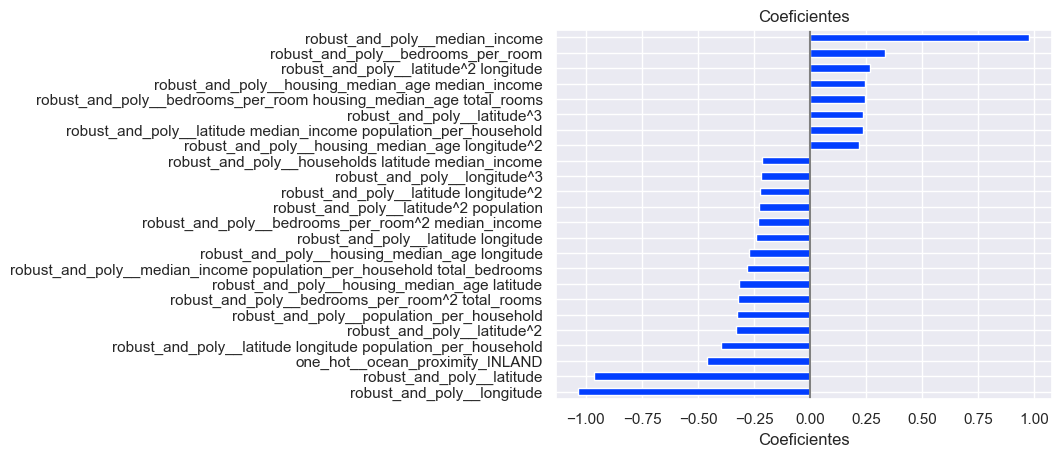

In [16]:
# Selecionando os mais relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.2, 0.2)])

`median_income`, isto é, renda como sendo o coeficiente positivo de maior valor, `latitude` e `longitude` sendo os coeficientes negativos de maior valores. Então quando temos um procedimento de regularização que tem o objetivo de diminuir os coeficientes de features que contribuem pouco para o **Target**, voltamos a ver *Renda* e *Localização* como sendo variáveis importantes para essa finalidade. E se observarmos as combinações de features gerado pelo **PolynomialFeatures**, veremos que possuem alguma contribuição de *Renda* ou *Localização*.

In [17]:
# Recriando o dicionário de regressores para a nova análise
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinearRegression': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
    'LinearRegression_target': {
        'preprocessor': preprocessamento,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal'),
    },
    'Ridge_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_,
    },
}

In [18]:
# Treinando e validando os modelos do dicionário de regressores. Transformando os resultados em um DF.
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **modelo_etapas)
    for nome_modelo, modelo_etapas in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00259,0.01447,-0.000081,-77516.042766,-96239.705692,0.017061
1,DummyRegressor,0.007293,0.008689,-0.000146,-75787.787194,-95217.629397,0.015981
2,DummyRegressor,0.006,0.008003,-0.001737,-76753.598961,-96253.253947,0.014003
3,DummyRegressor,0.0,0.016136,-0.000101,-76837.804811,-95983.885799,0.016136
4,DummyRegressor,0.0,0.0,-0.000114,-76617.245449,-96182.764729,0.0
5,LinearRegression,0.073502,0.021947,0.682162,-39855.690996,-54254.958188,0.095449
6,LinearRegression,0.070781,0.023238,0.66999,-40272.565467,-54695.230283,0.094019
7,LinearRegression,0.088483,0.019919,0.649247,-42178.05929,-56955.988706,0.108402
8,LinearRegression,0.073188,0.022964,0.669873,-40806.492497,-55146.318803,0.096152
9,LinearRegression,0.066383,0.028872,0.669023,-40788.496497,-55331.35106,0.095256


In [19]:
df_resultados.groupby('model').mean().sort_values(by='time_seconds')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.003177,0.00946,-0.000436,-76702.495836,-95975.447913,0.012636
LinearRegression,0.074468,0.023388,0.668059,-40780.26095,-55276.769408,0.097856
LinearRegression_target,0.101751,0.023474,0.67827,-38672.885265,-54416.606017,0.125226
Ridge_grid_search,0.286423,0.046471,0.723552,-35334.857193,-50433.820125,0.332895


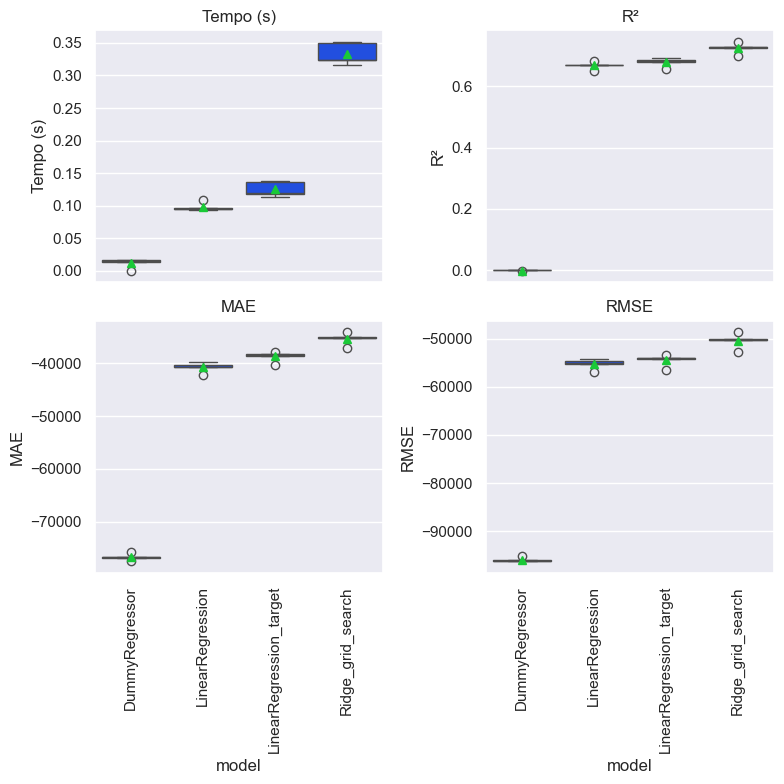

In [20]:
plot_comparar_metricas_modelos(df_resultados)

- De fato o **ElasticNet** era um modelo mais pesado para ser executado, pois ele tinha demorado praticamente 10x mais que o modelo simples de **LinearRegression**, mas o **Ridge** foi bem mais rápido. Claro que ele ainda é mais demorado que o modelo mais simples, pois ele possui uma maior complexidade, mas pelo ganho na métrica ele parece valer a pena

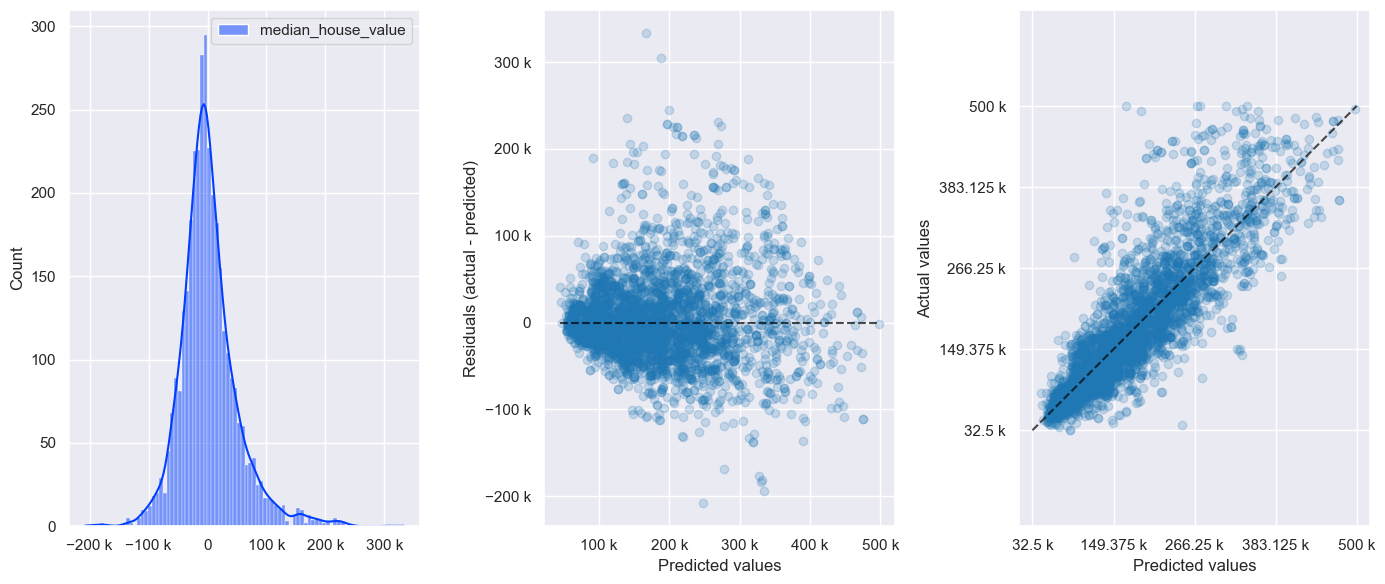

In [21]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.2, eng_formatter=True)

### Conclusão:
- Realizamos uma sequência de testes até aqui, fazendo alterações e manipulação com `transformadores`, tanto de *escala* quanto de *target*, e chegamos a conclusão de que o **QuantileTransformer** parece ser o mais adequado para esses dados.

- Em seguida, também introduzimos a técnica de *features polinomiais*, e de fato tivemos alguma melhora nas métricas de interesse, porém isso aumentou a complexidade do modelo dificultando sua interpretação, para resolver esse problema aplicamos a técnica de *Regularização*, e através das análises determinamos que o **Ridge** parecia fazer mais sentido; Selecionamos esse modelo, otimizamos os parâmetros do modelo, otimizamos os parâmetros do Quantile e chegamos a esse modelo final.

In [22]:
# Exportando modelo final
dump(grid_search.best_estimator_, MODELO_FINAL)

['C:\\Users\\zeygl\\OneDrive\\Documentos\\hashtag_curso\\projeto_casas\\modelos\\ridge_polyfeat_target_quantile.joblib']